In [1]:
import investpy
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
import investpy
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from pathlib import Path

In [2]:
df = investpy.get_index_historical_data(index="bse sensex", country="INDIA", from_date="01/01/2000", to_date="19/07/2021")
df.to_csv('SensexHistoricalData.csv')

In [3]:
# file_path = str(Path(__file__).resolve().parent.parent) + \
#     '\\static\\machine_learning\\prediction'


def get_data(name, column):
    """ Fetches the data from the Investing.com API\n 
        Takes the name as a parameter in format of 
        yfinance abbriviations """

    now = datetime.datetime.now().date()
    now = f'{now.day}/{now.month}/{now.year}'

    df = investpy.get_index_historical_data(
        index=name, from_date="01/01/2000", to_date=now, country="INDIA")
    df.drop(['Volume', 'Currency'], axis=1, inplace=True)
    dataset = df.filter([column])
    print(df.head(), dataset)
    return df, dataset


def scale_data(dataset):
    """ Scales the dataset in the range (0,1) suitable for the
        LSTM model.\n Takes dataset as an argument of the type dataframe"""

    scalar = MinMaxScaler(feature_range=(0, 1))
    train = scalar.fit_transform(dataset)
    return train, scalar


def create_prediction_list(train, n_input, model):
    """ Creates a prediction list which contains the value of 
        all the predictions made from the predict_data function """

    pred_list = []
    batch = train[-n_input:].reshape((1, n_input, 1))
    for i in range(n_input):
        pred_list.append(model.predict(batch)[0])
        batch = np.append(batch[:, 1:, :], [[pred_list[i]]], axis=1)
    return pred_list


def create_future_dates_list(df, n_input):
    """ Creates a list containing the future dates of the list in 1 day interval"""

    add_dates = [df.index[-1] +
                 pd.DateOffset(days=x) for x in range(0, n_input+1)]
    future_dates = pd.DataFrame(index=add_dates[1:], columns=df.columns)
    return future_dates


def proj_dataset(scalar, pred_list, future_dates, n_input, df):
    """ Creates a dataframe containing both the previous and the final data"""

    df_predict = pd.DataFrame(scalar.inverse_transform(
        pred_list), index=future_dates[-n_input:].index, columns=['Prediction'])
    df_proj = pd.concat([df, df_predict], axis=1)
    return df_proj


def predict_data(epoch, n_input, train, name, column):
    """ Makes actual predictions of the data inputted """

    # creating a time series generator
    generator = TimeseriesGenerator(
        train, train, length=n_input, batch_size=10)

    # creating the LSTM model
    model = Sequential()

    model.add(LSTM(100, activation="relu", batch_input_shape=(n_input, 1), stateful=True))

    model.add(Dropout(0.2))

    model.add(Dense(1, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy'
    )

    # Train the model
    # if os.path.exists(file_path + f'\\{name}\\{column}\\prediction.json'):
    #     # load json and create model
    #     json_file = open(
    #         file_path + f'\\{name}\\{column}\\prediction.json', 'r')

    #     loaded_model_json = json_file.read()
    #     json_file.close()
    #     model = model_from_json(loaded_model_json)

    #     # load weights into new model
    #     model.load_weights(
    #         file_path + f'\\{name}\\{column}\\prediction.h5')

    #     model.save(
    #         file_path + f'\\{name}\\{column}\\prediction.hdf5')
    #     model = load_model(
    #         file_path + f'\\{name}\\{column}\\prediction.hdf5')
    # else:
    #     model.fit(generator, epochs=epoch, verbose=1)
    #     with open(file_path + f'\\{name}\\{column}\\prediction.json', "w") as json_file:
    #         json_file.write(model.to_json())
    #     model.save_weights(
    #         file_path + f'\\{name}\\{column}\\prediction.h5')
    history = model.fit(generator, epochs=epoch, verbose=1)
    losses = history.history['loss']
    plt.figure(figsize=(20,8))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(0, epoch+1, 1))
    plt.plot(range(len(losses)), losses)

    return model


def timeseries_prediction(days, index, column, epoch):

    df, dataset = get_data(index, column)
    train, scalar = scale_data(dataset)
    future_dates = create_future_dates_list(df, days)

    model = predict_data(epoch, days, train, index, column)

    pred_list = create_prediction_list(train, days, model)

    df_proj = proj_dataset(scalar, pred_list, future_dates, days, df)

    return df_proj


               Open     High      Low   Close
Date                                         
2000-01-03  1482.15  1592.90  1482.15  1592.2
2000-01-04  1594.40  1641.95  1594.40  1638.7
2000-01-05  1634.55  1635.50  1555.05  1595.8
2000-01-06  1595.80  1639.00  1595.80  1617.6
2000-01-07  1616.60  1628.25  1597.20  1613.3                 Open
Date                
2000-01-03   1482.15
2000-01-04   1594.40
2000-01-05   1634.55
2000-01-06   1595.80
2000-01-07   1616.60
...              ...
2021-07-13  15794.00
2021-07-14  15808.70
2021-07-15  15872.15
2021-07-16  15958.35
2021-07-19  15740.25

[5360 rows x 1 columns]
Epoch 1/10
533/533 [==============================] - 10s 16ms/step - loss: nan
Epoch 2/10
533/533 [==============================] - 8s 16ms/step - loss: nan
Epoch 3/10
533/533 [==============================] - 8s 14ms/step - loss: nan
Epoch 4/10
533/533 [==============================] - 8s 15ms/step - loss: nan
Epoch 5/10
533/533 [==============================] - 10s 18ms/

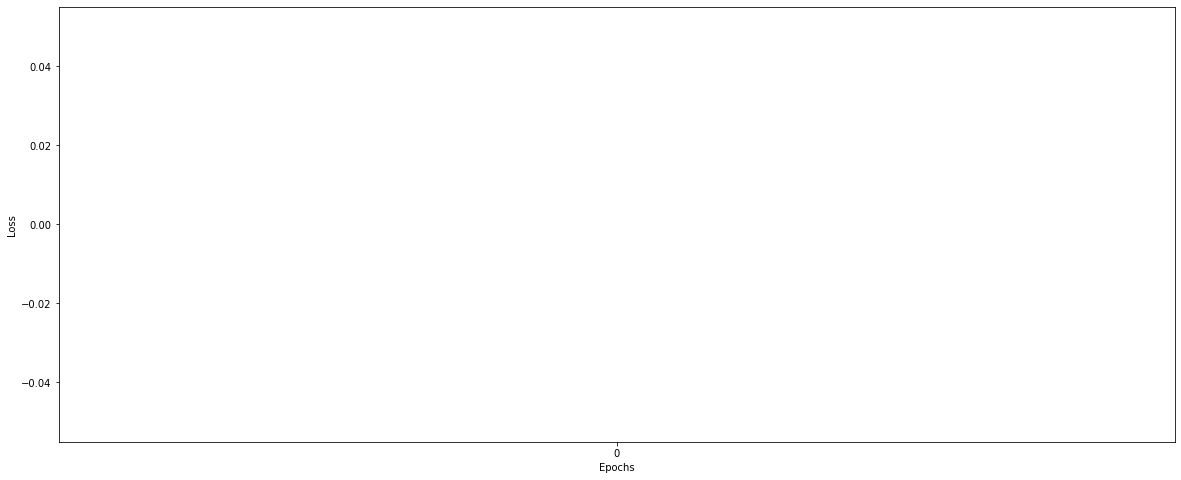

In [4]:
df_prj = timeseries_prediction(30, "nifty 50", 'Open', 1000)

               Open     High      Low   Close  Prediction
2000-01-03  1482.15  1592.90  1482.15  1592.2         NaN
2000-01-04  1594.40  1641.95  1594.40  1638.7         NaN
2000-01-05  1634.55  1635.50  1555.05  1595.8         NaN
2000-01-06  1595.80  1639.00  1595.80  1617.6         NaN
2000-01-07  1616.60  1628.25  1597.20  1613.3         NaN
...             ...      ...      ...     ...         ...
2021-08-14      NaN      NaN      NaN     NaN         NaN
2021-08-15      NaN      NaN      NaN     NaN         NaN
2021-08-16      NaN      NaN      NaN     NaN         NaN
2021-08-17      NaN      NaN      NaN     NaN         NaN
2021-08-18      NaN      NaN      NaN     NaN         NaN

[5390 rows x 5 columns]


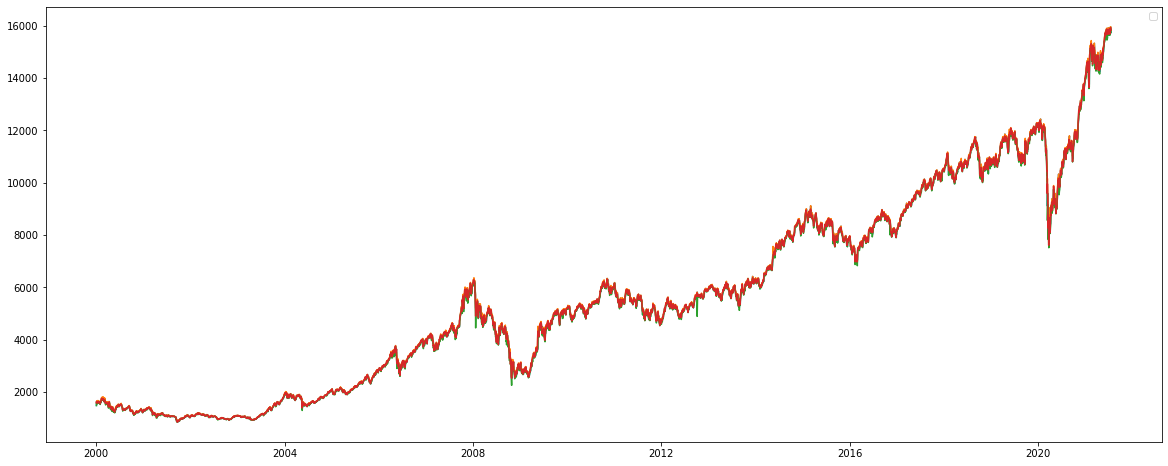

In [6]:
print(df_prj)
plt.figure(figsize=(20,8))
plt.legend(df_prj)
plt.plot(df_prj)